# Random Graph Models

This tutorial will introduce the following random graph models: 
 - Erdos-Reyni (ER)
 - Degree-corrected Erdos-Reyni (DCER)
 - Stochastic block model (SBM)
 - Degree-corrected stochastic block model (DCSBM)
 - Random dot product graph (RDPG)

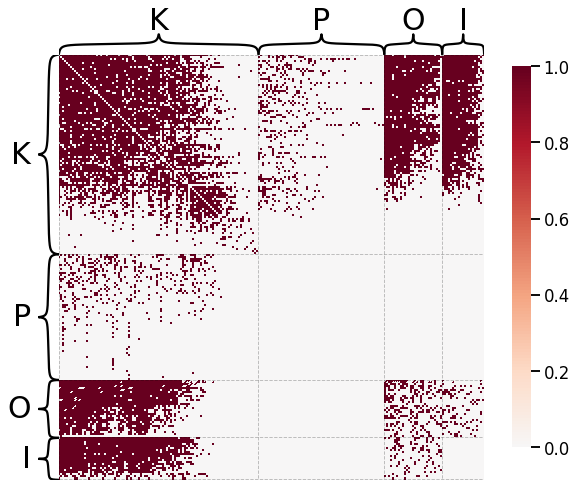

In [1]:
import numpy as np 
from graspy.datasets import load_drosophila_right
from graspy.plot import heatmap
from graspy.utils import binarize, symmetrize
%matplotlib inline
adj, labels = load_drosophila_right(return_labels=True)
adj = symmetrize(adj, method='avg')
adj = binarize(adj)
heatmap(adj, inner_hier_labels=labels, transform='simple-nonzero');

# Erdos-Reyni
The Erdos-Reyni (ER) model is the simplest random graph model one could write down. We are interested in modeling the probability of an edge existing between any two nodes, $i$ and $j$. We denote this probability $P_{ij}$. For the ER model:

$$P_{ij} = p$$

for any combination of $i$ and $j$

This means that the one parameter $p$ is the overall probability of connection for any two nodes. 

ER "p" parameter: 0.2479666732791113


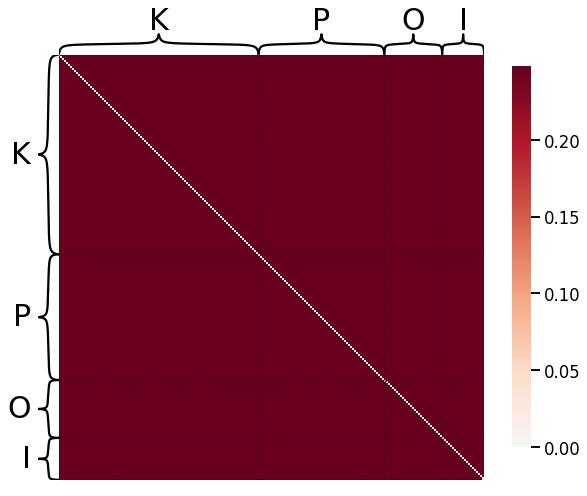

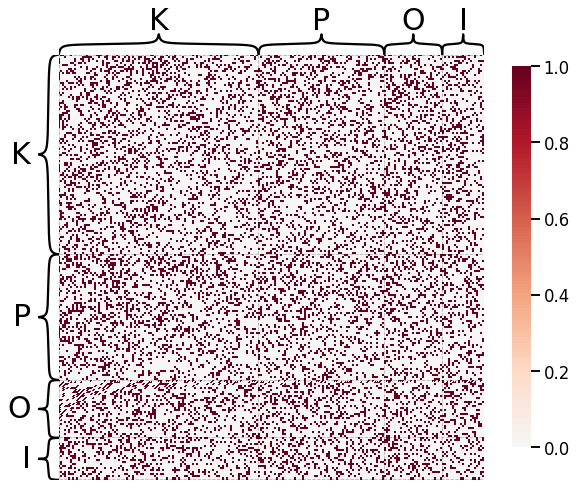

In [2]:
from graspy.models import EREstimator
er = EREstimator(directed=True,loops=False)
er.fit(adj)
print(f"ER \"p\" parameter: {er.p_}")
heatmap(er.p_mat_, inner_hier_labels=labels,)
heatmap(er.sample()[0], inner_hier_labels=labels,);

# Degree-corrected Erdos-Reyni

A slightly more complicated variant of the ER model is the degree-corrected Erdos-Reyni model (DCER). Here, there is still a global parameter $p$ to specify relative connection probability between all edges. However, we add a promiscuity parameter $\theta_i$ for each node $i$ which specifies its expected degree relative to other nodes:

$$P_{ij} = \theta_i \theta_j p$$

so the probility of an edge from $i$ to $j$ is a function of the two nodes' degree-correction parameters, and the overall probability of an edge in the graph. 

ER "p" parameter: 11250.0


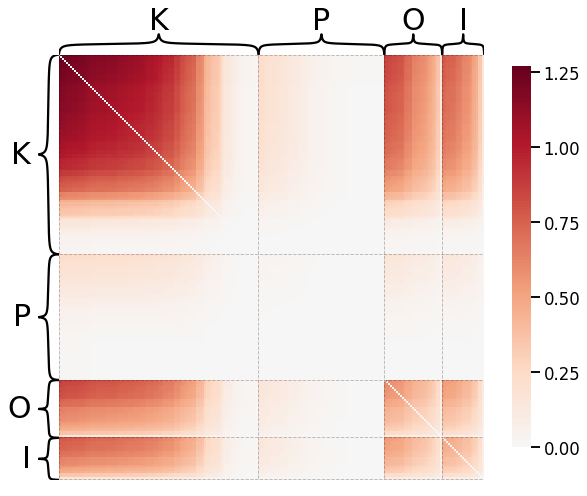

In [84]:
from graspy.models import DCEREstimator
dcer = DCEREstimator(directed=True,loops=False)
dcer.fit(adj)
print(f"ER \"p\" parameter: {dcer.p_}")
heatmap(dcer.p_mat_, inner_hier_labels=labels,);
# heatmap(dcer.sample()[0], inner_hier_labels=labels,);

In [67]:
from sklearn.linear_model import LinearRegression

def get_p_mat(adj, weight=1, c=0):
    n_verts = adj.shape[0]
    m = np.sum(adj)
    p_mat = np.zeros((n_verts, n_verts))
    for i in range(n_verts):
        for j in range(n_verts):
            dj = np.sum(adj[j,:])
            di = np.sum(adj[i,:])
            p = dj * di / m
            p_mat[i, j] = p
    p_mat = p_mat * weight + c
    p_mat = p_mat - np.diag(np.diag(p_mat))
    return p_mat, (1 / m)


def score_samples(p_mat, graph):
        """
        Compute the weighted log probabilities for each potential edge.

        Note that this implicitly assumes the input graph is indexed like the 
        fit model.

        Parameters
        ----------
        graph : np.ndarray
            input graph

        Returns
        -------
        sample_scores : np.ndarray (size of `graph`)
            log-likelihood per potential edge in the graph
        """
        p_mat = p_mat.copy()
        
        # squish the probabilities that are degenerate
#         c = 0# 1 / graph.size
#         p_mat[p_mat < c] = c
#         p_mat[p_mat > 1 - c] = 1 - c
        # TODO: use nonzero inds here will be faster
        successes = np.multiply(p_mat, graph)
        failures = np.multiply((1 - p_mat), (1 - graph))
        likelihood = successes + failures
        return np.log(likelihood)
    
def score(p_mat, graph):
        """
        Compute the average log-likelihood over each potential edge of the 
        given graph.

        Note that this implicitly assumes the input graph is indexed like the 
        fit model.

        Parameters
        ----------
        graph : np.ndarray
            input graph

        Returns
        -------
        score : float
            sum of log-loglikelihoods for each potential edge in input graph
        """
        return np.sum(score_samples(p_mat, graph))

In [47]:
weights = np.linspace(0, .25, num=10)
cs = np.linspace(0,1, num=40)
scores = np.zeros((len(cs), len(weights)))
for i, w in enumerate(weights):
    for j, c in enumerate(cs):
        p_mat = get_p_mat(adj, weight=w, c=c)
        scores[j,i] = score(p_mat, adj)

x, y = np.meshgrid(weights, cs)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, scores);
# # plt.plot(scores)

ModuleNotFoundError: No module named 'sklearn.regression'

In [79]:
i, j = np.where(scores == np.nanmax(scores))
j
i
scores[i, j]
np.nanmax(scores)

array([9])

array([5])

array([-20257.43736244])

-20257.437362438068

11250.0


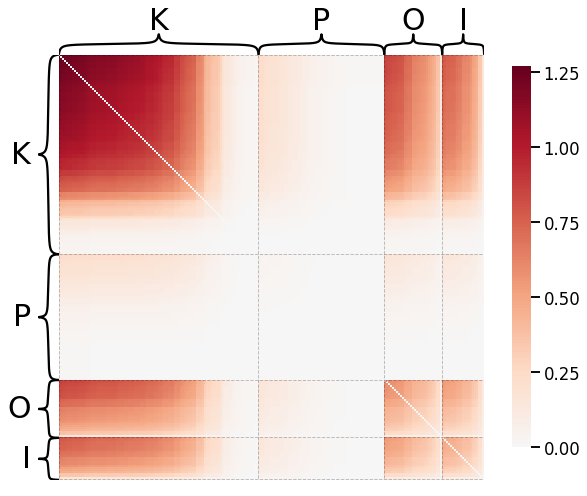

In [80]:
from graspy.simulations import sample_edges
p_mat, m = get_p_mat(adj,)
heatmap(p_mat, inner_hier_labels=labels);
# heatmap(sample_edges(p_mat), inner_hier_labels=labels)
print(1/m)

In [81]:
from graspy.simulations import sample_edges
p_mat, m = get_p_mat(adj, weight=weights[j], c=cs[i])
heatmap(p_mat, inner_hier_labels=labels)
heatmap(sample_edges(p_mat), inner_hier_labels=labels);

ValueError: Found input variables with inconsistent numbers of samples: [2, 213]

11308.2500206892


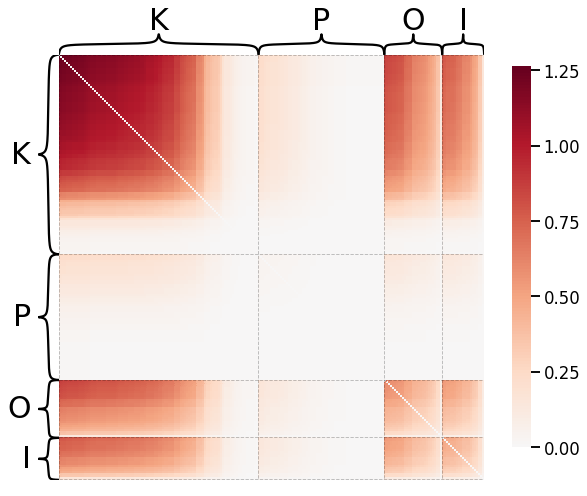

In [83]:



from graspy.simulations import sample_edges
p_mat, m = get_p_mat_mse(adj, )
heatmap(p_mat, inner_hier_labels=labels)
# heatmap(sample_edges(p_mat), inner_hier_labels=labels);
print(1/m);`